With this notebook we want to test how many and which of the important features have been exploited by each isolation tree in a given isolation forest.

In [1]:
import os
import numpy as np
import pickle as pkl 
# import time
import matplotlib.pyplot as plt 
%matplotlib inline
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.utils import shuffle
# import shap
# import diffi.interpretability_module as interp
from diffi.utils import *

/Users/sebastianosanson/Documents/Master Thesis/Master-Thesis/mt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
with open(os.path.join(os.getcwd(), 'dataset', 'syn_train.pkl'), 'rb') as f:
    data_tr = pkl.load(f)
with open(os.path.join(os.getcwd(), 'dataset', 'syn_test.pkl'), 'rb') as f:
    data_te = pkl.load(f)

X_tr = data_tr.iloc[:, :-1]
y_tr = data_tr.iloc[:, -1]

X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

X_te = data_te.iloc[:, :-1]
y_te = data_te.iloc[:, -1]


In [3]:
print('Training set size: ', X_tr.shape)
print('Trainin label size: ', y_tr.shape)

print('Test set size: ', X_te.shape)
print('Test label size: ', y_te.shape)

Training set size:  (1000, 20)
Trainin label size:  (1000,)
Test set size:  (100, 20)
Test label size:  (100,)


## Train the Isolation Forest

In [4]:
sorted_idx, avg_f1, fi_means, fi_std, features_per_forest, fi_diffi_all, iforests = diffi_ranks(X=X_tr.to_numpy(), y=y_tr.to_numpy(), n_trees=100, 
                                                                        max_samples=256, n_iter=1, contamination=0.1)
print('Average F1 score: {:.4f}'.format(avg_f1))
# print('Ranked features: ', sorted_idx)
# print('Feature importance means: ', fi_means)
# print('Feature importance std: ', fi_std)        

Average F1 score: 0.4300


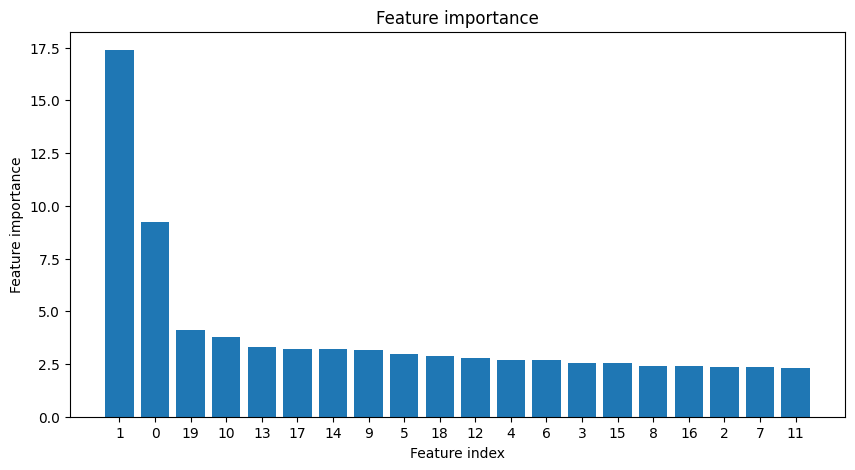

In [5]:
# plot the features importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx)), fi_means[sorted_idx], yerr=fi_std[sorted_idx])
plt.xticks(range(len(sorted_idx)), sorted_idx)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importance')
plt.show()

Notice that the two most important features are the meaningful ones, while the other are the noise ones (in according to synthetic dataset).

In [6]:
two_most_important_features = sorted_idx[:2]
print('Two most important features:', two_most_important_features)

Two most important features: [1 0]


In [7]:
features_per_forest = np.array(features_per_forest, dtype=object)
# print(features_per_forest.shape)  
print('Number of forest/s: ', len(features_per_forest))
print('Number of tree/s: ', [len(features_per_forest[i]) for i in range(len(features_per_forest))])

# for i, forest in enumerate(features_per_forest):
#     print('Forest {}:'.format(i))
#     for j, tree in enumerate(forest):
#         print('Number of features in tree {}: {}'.format(j, len(tree)))
#         print('Features in tree {} in forest {}: {}'.format(j, i, tree))

Number of forest/s:  1
Number of tree/s:  [100]


## Global features usage in Isolation Forest

We compute the usage of each feature over the Isolation Forest

In [8]:
usage_per_forest = np.zeros((len(features_per_forest), X_tr.shape[1]), 
                            dtype=object)    # shape: (number of forests, number of features)
usage_per_tree = np.zeros((len(features_per_forest), len(features_per_forest[0]), X_tr.shape[1]), 
                          dtype=object)  # shape: (number of forests, number of trees, number of features)


for i in range(X_tr.shape[1]):                                                      # for each feature                                     
    for j, forest in enumerate(features_per_forest):                                # for each forest
        for k, tree in enumerate(forest):                                           # for each tree
            # count the number of times feature i is used in tree k in forest j
            usage_per_tree[j, k, i] = np.sum([1 for feature in tree if feature == i])   
        # count the number of times feature i is used in forest j
        usage_per_forest[j, i] = np.sum(usage_per_tree[j, :, i])                          

print(np.array(usage_per_tree, dtype=object).shape)
print(np.array(usage_per_forest, dtype=object).shape)

(1, 100, 20)
(1, 20)


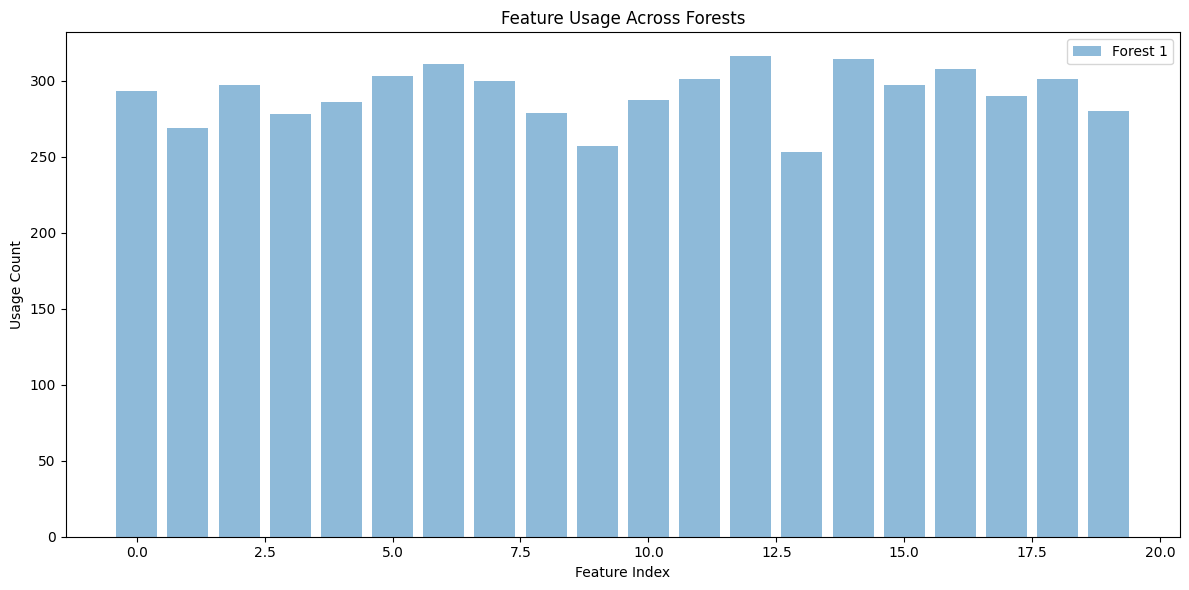

In [9]:
plt.figure(figsize=(12, 6))
for i in range(usage_per_forest.shape[0]):
    plt.bar(range(usage_per_forest.shape[1]), usage_per_forest[i], alpha=0.5, label=f'Forest {i+1}')
plt.xlabel('Feature Index')
plt.ylabel('Usage Count')
plt.title('Feature Usage Across Forests')
plt.legend()
plt.tight_layout()
plt.show()

## `two_most_important_features` usage 

Counting how many times the `two_most_important_features`are used in each Isolation Tree

In [10]:
num_forests = len(features_per_forest)
num_trees = len(features_per_forest[0])

two_most_important_features_usage = np.zeros((len(two_most_important_features), 
                                              num_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)
# print(two_most_important_features_usage.shape)

for i in range(len(two_most_important_features)):
    for j, forest in enumerate(features_per_forest):
        for k, tree in enumerate(forest):
            two_most_important_features_usage[i, j, k] = usage_per_tree[j, k, i] / len(tree)  

print('Two most important features usage:', two_most_important_features_usage)

Two most important features usage: [[[0.02857143 0.03007519 0.02721088 0.01123596 0.03870968 0.
   0.03508772 0.04316547 0.02521008 0.         0.00826446 0.01438849
   0.00917431 0.01886792 0.04511278 0.01481481 0.03076923 0.00613497
   0.03546099 0.         0.00840336 0.05035971 0.06060606 0.01574803
   0.01769912 0.06766917 0.02013423 0.02857143 0.01863354 0.05405405
   0.05426357 0.02105263 0.         0.01204819 0.01265823 0.
   0.01694915 0.02597403 0.03738318 0.         0.04       0.03448276
   0.04273504 0.0173913  0.02484472 0.01960784 0.         0.00740741
   0.01459854 0.04137931 0.02362205 0.02752294 0.02040816 0.01204819
   0.02298851 0.02197802 0.01438849 0.03184713 0.01834862 0.04242424
   0.00826446 0.04065041 0.         0.04026846 0.07070707 0.01869159
   0.00787402 0.03589744 0.00564972 0.0130719  0.016      0.04458599
   0.01098901 0.         0.02362205 0.03296703 0.01459854 0.04761905
   0.03007519 0.0173913  0.02247191 0.01818182 0.02923977 0.02247191
   0.01910828 0

Now we are going to normalize the results to the range [0, 1]

In [11]:
two_most_important_features_usage_probabilities = np.zeros((len(two_most_important_features), 
                                                            num_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)

for i, feature in enumerate(two_most_important_features_usage):
    for j, forest in enumerate(feature):
        max = np.max(forest)
        for k, tree in enumerate(forest):
            two_most_important_features_usage_probabilities[i, j, k] = two_most_important_features_usage[i, j, k] / max

print('Two most important features usage probabilities:', two_most_important_features_usage_probabilities)

Two most important features usage probabilities: [[[0.40408163 0.42534909 0.38483965 0.15890851 0.54746544 0.
   0.4962406  0.61048304 0.35654262 0.         0.11688312 0.20349435
   0.12975098 0.26684636 0.63802363 0.20952381 0.43516484 0.08676599
   0.50151976 0.         0.11884754 0.71223022 0.85714286 0.22272216
   0.25031606 0.95703545 0.28475551 0.40408163 0.2635315  0.76447876
   0.76744186 0.29774436 0.         0.17039587 0.17902351 0.
   0.23970944 0.36734694 0.52870494 0.         0.56571429 0.48768473
   0.6043956  0.24596273 0.35137533 0.27731092 0.         0.1047619
   0.20646507 0.58522167 0.33408324 0.38925295 0.28862974 0.17039587
   0.32512315 0.31083203 0.20349435 0.45040946 0.25950197 0.6
   0.11688312 0.57491289 0.         0.56951103 1.         0.26435247
   0.11136108 0.50769231 0.07990315 0.18487395 0.22628571 0.63057325
   0.15541601 0.         0.33408324 0.46624804 0.20646507 0.67346939
   0.42534909 0.24596273 0.31781701 0.25714286 0.41353383 0.31781701
   0.2702

Plotting the usage probabilities of `two_most_important_features` across isolation trees

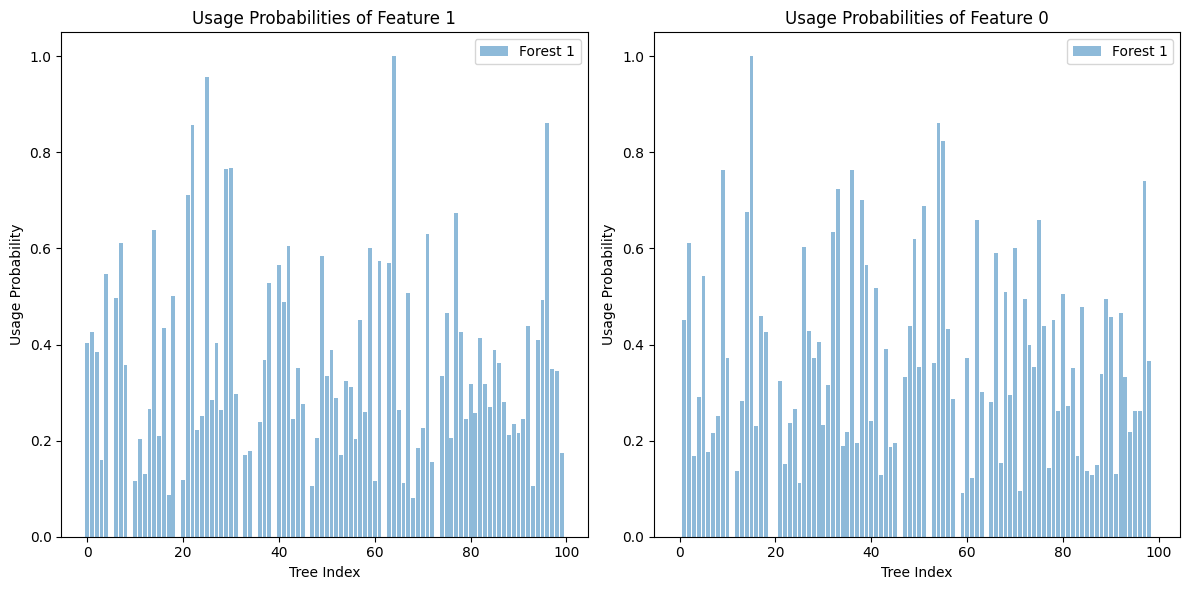

In [12]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.subplot(1, 2, i+1)
    for j in range(num_forests):
        plt.bar(range(num_trees), two_most_important_features_usage_probabilities[i, j, :], alpha=0.5, label=f'Forest {j+1}')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Probability')
    plt.title(f'Usage Probabilities of Feature {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

## Average usage

Calculating the average of the `two_most_important_features_usage_probabilities` for each `two_most_important_features`

In [13]:
average_usage_probabilities = np.zeros((len(two_most_important_features), num_forests))    # shape: (number of meaningful features, number of forests)
for i in range(len(two_most_important_features)):
    for j in range(num_forests):
        average_usage_probabilities[i, j] = np.mean(two_most_important_features_usage_probabilities[i, j, :])
print('Average usage probabilities:', average_usage_probabilities)
# np.mean(two_most_important_features_usage_probabilities, axis=1)
# for i, feature in enumerate(two_most_important_features):
#     print(f"Average usage probability for Feature {feature}: {average_usage_probabilities[i]:.4f}")

Average usage probabilities: [[0.33582968]
 [0.34879514]]


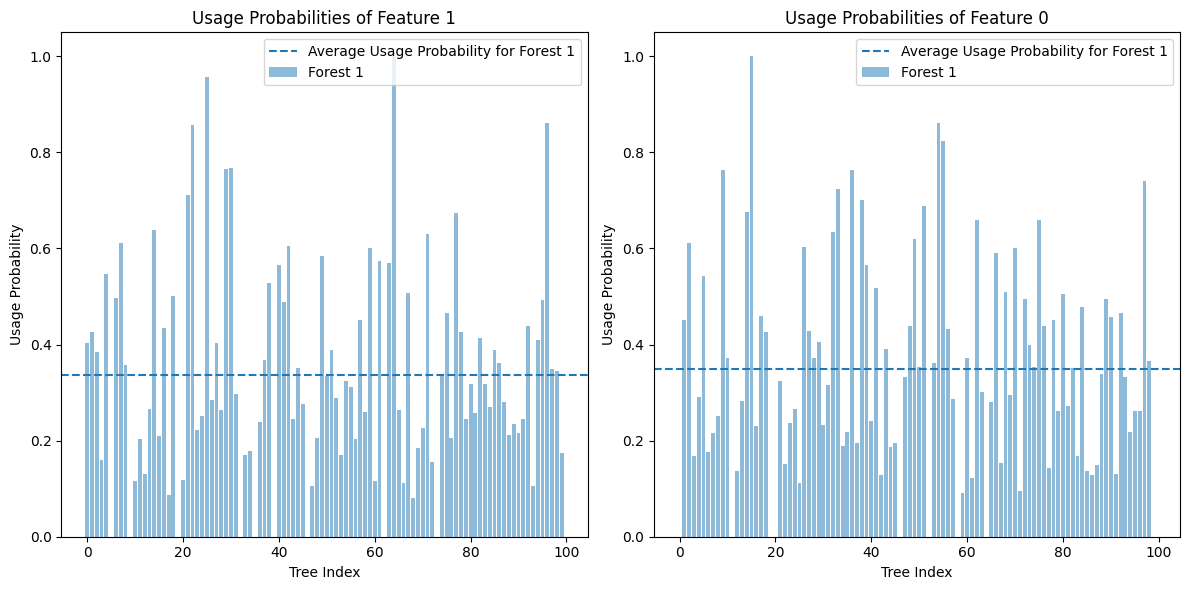

In [14]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.subplot(1, 2, i+1)
    for j in range(num_forests):
        plt.bar(range(num_trees), two_most_important_features_usage_probabilities[i, j, :], alpha=0.5, label=f'Forest {j+1}')
        plt.axhline(y=average_usage_probabilities[i, j], color=f'C{j}', linestyle='--', label=f'Average Usage Probability for Forest {j+1}')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Probability')
    plt.title(f'Usage Probabilities of Feature {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# save indexes of the trees to be removed
tree_idx = np.zeros((len(two_most_important_features), num_forests), dtype=object)  # shape: (number of meaningful features, number of forests)
print(tree_idx.shape)

for i, feature in enumerate(two_most_important_features_usage_probabilities):
    for j, forest in enumerate(feature):
        tree_idx[i, j] = np.where(forest < 0.2)[0]  # get the indexes of the trees where the usage probability is less than 0.2
        print(f"Feature {two_most_important_features[i]} in Forest {j+1} has trees with usage probability < 0.2: {tree_idx[i, j]}")


(2, 1)
Feature 1 in Forest 1 has trees with usage probability < 0.2: [ 3  5  9 10 12 17 19 20 32 33 34 35 39 46 47 53 60 62 66 68 69 72 73 93
 99]
Feature 0 in Forest 1 has trees with usage probability < 0.2: [ 0  3  6 11 12 19 20 22 25 34 37 42 44 45 46 52 58 59 61 64 67 71 77 83
 85 86 87 91 99]


In [16]:
tree_to_be_removed = np.zeros(num_forests, dtype=object)
print(tree_to_be_removed.shape)

for i in range(num_forests):
    concatenated = np.concatenate(([feature[i] for feature in tree_idx]), axis=0)
    # print('concatenated: {}'.format(concatenated))
    concatenated = np.unique(concatenated)
    # print('unique: {}'.format(concatenated))
    tree_to_be_removed[i] = concatenated

print(tree_to_be_removed)
print('Number of trees to be removed: ', [len(tree_to_be_removed[i]) for i in range(len(tree_to_be_removed))])

(1,)
[array([ 0,  3,  5,  6,  9, 10, 11, 12, 17, 19, 20, 22, 25, 32, 33, 34, 35,
        37, 39, 42, 44, 45, 46, 47, 52, 53, 58, 59, 60, 61, 62, 64, 66, 67,
        68, 69, 71, 72, 73, 77, 83, 85, 86, 87, 91, 93, 99])               ]
Number of trees to be removed:  [47]


In [17]:
for i, forest in enumerate(iforests):
    print('Forest {}:'.format(i))
    # get the list of trees
    trees = forest.estimators_
    my_trees = trees.copy()
    # print('orginal trees', trees)
    # print('copy trees', my_trees)
    print('Number of trees: ', len(trees))
    for _, tree_idx in enumerate(tree_to_be_removed[i]):
        # print('Tree to be removed: ', tree_idx)
        # remove the tree
        trees.remove(my_trees[tree_idx])
    # print('Trees after removing: ', trees)

Forest 0:
Number of trees:  100


In [18]:
for i, forest in enumerate(iforests):
    print('Forest {}:'.format(i))
    # get the list of trees
    trees = forest.estimators_
    print('Number of trees after removing: ', len(trees))
    # print('Trees after removing: ', trees)

Forest 0:
Number of trees after removing:  53


In [19]:
f1_all = []
for i, forest in enumerate(iforests):
    # get predictions
    y_pred = np.array(forest.decision_function(X_tr.to_numpy()) < 0).astype('int')   # > 0 -> True -> 1; < 0 -> False -> 0 
    # get performance metrics
    f1_all.append(f1_score(y_tr.to_numpy(), y_pred))
# compute avg F1 
new_avg_f1 = np.mean(f1_all)
print('Average F1 score: {:.4f}'.format(new_avg_f1))

IndexError: index 121 is out of bounds for axis 0 with size 105